# Navigation 2024 Manuscript Experiment 

Analysis used in:
> Dittmann, Morton, Chang (in prep) *Automated Classification of Cubesat GNSS-RO Disturbances*


## In this Experiment:
1. [Data Preparation](#1-data-preparation)
2. [Model Training and Testing](#2-model-training-and-testing)
3. [ML Models Comparison](#3-ml-models-comparison)  
4. [Visualize selected model performance and interpretability](#4-visualize-selected-model-performance-and-interpretability)
5. [Determine optimal thresholds to compare against ML](#5-determine-optimal-thresholds-to-compare-against-ml)
    * RFI Threshold
    * Scintillation Threshold
6. [Examples of model performance](#6-examples-of-model-performance)

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sns


import sys  
sys.path.insert(1, '/home/stdi2687/leo-ml/scripts')

from feature_extract_util import *
from ml_util import labeldf_to_fsdf, class_map_RFI, df_2_Xy, sample_2_DFandXy, plot_leo_ml_multi
from ml_models import svc_model_train, xgb_model_train, rf_model_train

%load_ext autoreload
%autoreload 2

## 1. Data Preparation
* Feature sets to Feature and Target Vectors
* Train test splitting

This next cell split on events to keep certain events for testing.

The .pkl files are effectively the *catalogs* of samples that have been labeled through different notebooks targeting sample classes of interest across the data.



In [10]:
TEST_SIZE=0.3
LABELS=['Scint','Quiet','RFI','Artifact/Unknown','Severe Scint', 'Comms Link']
def cat_file_2_XYsplits(cat_file, TEST_SIZE):
    full_fdf=labeldf_to_fsdf(cat_file)

    # Convert to Feature and Target vectors 
    X, y, feature_names, fs_dict=df_2_Xy(full_fdf)

    #---- split data
    fs_df=pd.DataFrame(fs_dict)

    splitter = GroupShuffleSplit(test_size=TEST_SIZE, n_splits=1, random_state = 42)
    split = splitter.split(fs_df, groups=fs_df['sample'])
    train_inds, test_inds = next(split)
    return X, y, fs_dict, train_inds,test_inds, feature_names

In [4]:
# Read in catalog of labeled events
cat_file='../data/converted_labels.pkl'

# Convert catalog into feature and target vectors 
# and splits (train/test inds split at the profile level)
X, y, fs_dict, train_inds,test_inds, feature_names = cat_file_2_XYsplits(cat_file, TEST_SIZE)

X_train0=X[train_inds]
X_test0= X[test_inds]
y_train0=y[train_inds]
y_test0=y[test_inds]
lats_train0=fs_dict['lat_m'] [train_inds]
lats_test0=fs_dict['lat_m'] [test_inds]
hts_train0= fs_dict['occheight_m'][train_inds]
hts_test0= fs_dict['occheight_m'][test_inds]
samples_train0= fs_dict['sample'][train_inds]
samples_test0 =fs_dict['sample'][test_inds]

###########################
cat_file='../data/converted_labels_scint_v2.pkl'

# Convert catalog into feature and target vectors 
# and splits (train/test inds split at the profile level)
X, y, fs_dict, train_inds,test_inds, feature_names = cat_file_2_XYsplits(cat_file, TEST_SIZE)

X_train1=X[train_inds]
X_test1= X[test_inds]
y_train1=y[train_inds]
y_test1=y[test_inds]
lats_train1=fs_dict['lat_m'] [train_inds]
lats_test1=fs_dict['lat_m'] [test_inds]
hts_train1= fs_dict['occheight_m'][train_inds]
hts_test1= fs_dict['occheight_m'][test_inds]
samples_train1= fs_dict['sample'][train_inds]
samples_test1=fs_dict['sample'][test_inds]

## RFI downlink samples
cat_file='../data/converted_labels_comms.pkl'

# Convert catalog into feature and target vectors 
# and splits (train/test inds split at the profile level)
X, y, fs_dict, train_inds,test_inds, feature_names = cat_file_2_XYsplits(cat_file, TEST_SIZE)

# THIS IS IMPORTANT
# Changed RFI labeled during downlink to new class, seperate from
# Terrestrial RFI
# All labels from '../data/converted_labels_comms.pkl' are due to 
# downlinks
y=class_map_RFI(y)


X_train2=X[train_inds]
X_test2= X[test_inds]
y_train2=y[train_inds]
y_test2=y[test_inds]
lats_train2=fs_dict['lat_m'] [train_inds]
lats_test2=fs_dict['lat_m'] [test_inds]
hts_train2= fs_dict['occheight_m'][train_inds]
hts_test2= fs_dict['occheight_m'][test_inds]
samples_train2= fs_dict['sample'][train_inds]
samples_test2=fs_dict['sample'][test_inds]
#################

## RFI samples
cat_file='../data/converted_labels_rfi2_v2.pkl'

# Convert catalog into feature and target vectors 
# and splits (train/test inds split at the profile level)
X, y, fs_dict, train_inds,test_inds, feature_names = cat_file_2_XYsplits(cat_file, TEST_SIZE)

X_train3=X[train_inds]
X_test3= X[test_inds]
y_train3=y[train_inds]
y_test3=y[test_inds]
lats_train3=fs_dict['lat_m'] [train_inds]
lats_test3=fs_dict['lat_m'] [test_inds]
hts_train3= fs_dict['occheight_m'][train_inds]
hts_test3= fs_dict['occheight_m'][test_inds]
samples_train3= fs_dict['sample'][train_inds]
samples_test3=fs_dict['sample'][test_inds]
#################

X_train=np.vstack([X_train0,X_train1, X_train2,X_train3 ])
y_train=np.concatenate((y_train0,y_train1, y_train2, y_train3))
X_test=np.vstack([X_test0,X_test1, X_test2, X_test3])
y_test=np.concatenate((y_test0,y_test1, y_test2, y_test3))

samples_train=np.concatenate((samples_train0,samples_train1, samples_train2, samples_train3))
samples_test=np.concatenate((samples_test0,samples_test1, samples_test2, samples_test3))

(19, 64)
[Errno 2] No such file or directory: '../data/data/feature_sets/2023.144.103.17.02.G09.SC001_0001.pkl'
../data/data/feature_sets/2023.144.103.21.01.R05.SC001_0001.pkl 63
[Errno 2] No such file or directory: '../data/data/feature_sets/2023.144.103.21.02.R01.SC001_0001.pkl'
[Errno 2] No such file or directory: '../data/data/feature_sets/2023.144.103.22.01.R17.SC001_0001.pkl'
[Errno 2] No such file or directory: '../data/data/feature_sets/2023.144.103.23.02.G25.SC001_0001.pkl'
(3, 64)
(10, 64)
(24, 64)


In [5]:
# Check out distribution of samples
np.unique(y_train0, return_counts = True) + np.unique(y_test0, return_counts = True) +np.unique(y_train1, return_counts = True) + np.unique(y_test1, return_counts = True) +np.unique(y_train2, return_counts = True) + np.unique(y_test2, return_counts = True)+np.unique(y_train3, return_counts = True) + np.unique(y_test3, return_counts = True)

(array([0., 1., 2., 3.]),
 array([ 166, 6200,   64,  143]),
 array([0., 1., 2., 3.]),
 array([  92, 2768,   10,   54]),
 array([0., 1., 2., 3., 4.]),
 array([231, 443,   8,  20,  37]),
 array([0., 1., 3., 4.]),
 array([104, 205,  10,  12]),
 array([0., 1., 5.]),
 array([ 28, 591, 375]),
 array([0., 1., 5.]),
 array([ 13, 161, 147]),
 array([0., 1., 2., 3., 4.]),
 array([129, 614, 140,  16,   4]),
 array([0., 1., 2., 3.]),
 array([ 32, 266,  86,  36]))

## 2. Model training and Testing

In [6]:
version="10" # what does this mean?
#9 w/ seperate RFI classes (2 is RFI, 5 is downlink RFI)
#10 rerun for manuscript

rf_model=rf_model_train(X_train, y_train, version)
xgb_model=xgb_model_train(X_train, y_train,version)
svc_model=svc_model_train(X_train, y_train, version)

for model in [rf_model,xgb_model, svc_model]: # xgb_model,
    #--- test model
    y_pred = model.predict(X_test)
    print("\nConfusion matrix")
    print(confusion_matrix(y_test, y_pred))
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    print(X.shape, y.shape)
    print("\nResult")
    print(classification_report(y_test, y_pred))

    print(precision_recall_fscore_support(y_test, y_pred))


Best: 0.858771 using {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}

Best: 0.852580 using {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}

Best: 0.855783 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Confusion matrix
[[ 140   98    0    0    1    2]
 [  49 3289    8    6    1   47]
 [   6   73   17    0    0    0]
 [  35   53    0    8    3    1]
 [   2    0    2    0    8    0]
 [   0    7    0    0    0  140]]
(1323, 15) (1323,)

Result
              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59       241
         1.0       0.93      0.97      0.95      3400
         2.0       0.63      0.18      0.28        96
         3.0       0.57      0.08      0.14       100
         4.0       0.62      0.67      0.64        12
         5.0       0.74      0.95      0.83       147

    accuracy                           0.90      3996
   macro avg       0.68      0.57      0.57      3

Training complete!  
Models lives at ``

Selected 


In [7]:
ml_model=xgb_model

# whether or not to save plots on this run
plot_f=False

## 3. ML Models Comparison

[0.59196617 0.95057803 0.27642276 0.14035088 0.64       0.83086053]
0.8871414758009694
[0.58091286 0.96735294 0.17708333 0.08       0.66666667 0.95238095] [0.02450067 0.38758389 0.0025641  0.00154004 0.00125502 0.01299039] [0.9517017  0.91441441 0.97772773 0.97547548 0.99774775 0.98573574]
[0.61412151 0.94216362 0.4921466  0.20408163 0.57142857 0.82798834]
0.8877840984155521
[0.77593361 0.92470588 0.48958333 0.15       0.66666667 0.96598639] [0.0482024  0.21812081 0.01230769 0.00821355 0.00200803 0.01402962] [0.94119119 0.9034034  0.97572573 0.97072072 0.996997   0.98523524]
[0.44811321 0.94304978 0.34328358 0.192      0.2        0.75471698]
0.8708366234076031
[0.39419087 0.96676471 0.23958333 0.12       0.16666667 0.81632653] [0.02343542 0.47651007 0.00384615 0.00333676 0.00150602 0.01325019] [0.94144144 0.90065065 0.97797798 0.97472472 0.995996   0.98048048]


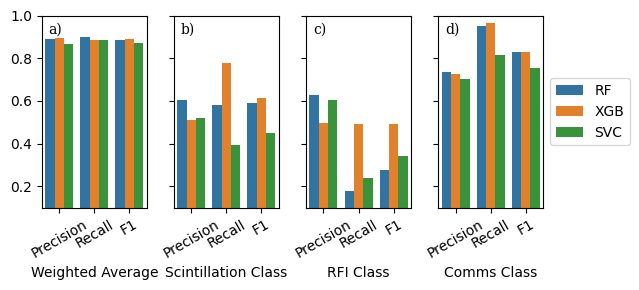

In [8]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb=xgb_model.predict(X_test) 
y_pred_svc=svc_model.predict(X_test)

def metrics_confusion(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, FPR, ACC

# need to do this for L1 and L2?

met_li=[]
for name,y_metric in zip(["RF", "XGB", "SVC"],[y_pred_rf, y_pred_xgb, y_pred_svc, ]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_test, y_metric)
    print(fscore)
    precision_w, recall_w, fscore_w, support=precision_recall_fscore_support(y_test, y_metric, average="weighted")
    print(fscore_w)
    met_li+=[np.array([[name, "Weighted Average", "Precision", precision_w],
                       [name, "Weighted Average","Recall", recall_w], 
                       [name, "Weighted Average","F1", fscore_w],
                       [name, "Scintillation Class", "Precision", precision[0]],
                       [name, "Scintillation Class","Recall", recall[0]], 
                       [name, "Scintillation Class","F1", fscore[0]],
                       [name, "RFI Class", "Precision", precision[2]],
                       [name, "RFI Class","Recall", recall[2]], 
                       [name, "RFI Class","F1", fscore[2]],
                       [name, "Comms Class", "Precision", precision[5]],
                       [name, "Comms Class","Recall", recall[5]], 
                       [name, "Comms Class","F1", fscore[5]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)

df_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Class", "Metric", "Score"])
df_met["Score"]=df_met.Score.astype(np.float16)

fig,ax=plt.subplots(1,4, sharey=True, figsize=(6.5,3))
for i,class_ in enumerate(["Weighted Average","Scintillation Class","RFI Class", "Comms Class"]):
    sns.barplot(df_met[df_met.Class==class_], x="Metric" , y="Score", hue="Model", ax=ax[i]).set(
    xlabel=class_, 
    ylabel=None
)
    #ax[i].legend(loc='upper left',ncol=3, title=class_)
    ax[i].legend_.remove()
    ax[i].set_ylim([.1,1.])
    ax[i].tick_params(axis='x', labelrotation=30)
# Put a legend to the right of the current axis
ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

import string
alph_li=list(string.ascii_lowercase)
alph_li=[s + ')' for s in alph_li]
for j,label in enumerate(alph_li[:len(ax)]):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    ax[j].annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
fig.tight_layout()
if plot_f:
    plt.savefig("../manuscript/compare_f1_ml.png", dpi=300)

## 4. Visualize selected model performance and interpretability


Confusion matrix
[[ 187   41    2    4    2    5]
 [ 137 3144   41   27    3   48]
 [   6   42   47    1    0    0]
 [  36   42    3   15    3    1]
 [   2    0    2    0    8    0]
 [   0    5    0    0    0  142]]
(1323, 15) (1323,)

Result
                  precision    recall  f1-score   support

           Scint       0.51      0.78      0.61       241
           Quiet       0.96      0.92      0.94      3400
             RFI       0.49      0.49      0.49        96
Artifact/Unknown       0.32      0.15      0.20       100
    Severe Scint       0.50      0.67      0.57        12
      Comms Link       0.72      0.97      0.83       147

        accuracy                           0.89      3996
       macro avg       0.58      0.66      0.61      3996
    weighted avg       0.90      0.89      0.89      3996

(array([0.50815217, 0.96029322, 0.49473684, 0.31914894, 0.5       ,
       0.7244898 ]), array([0.77593361, 0.92470588, 0.48958333, 0.15      , 0.66666667,
       0.96598639

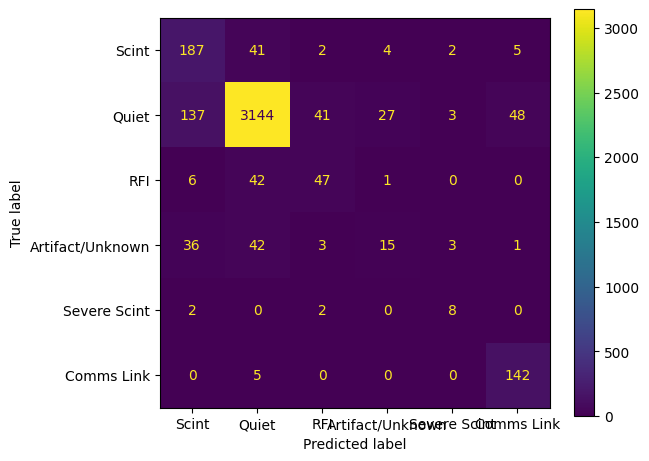

In [11]:
#--- test model
y_pred = ml_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
print("\nConfusion matrix")
print(confusion_matrix(y_test, y_pred))
y = y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
print(X.shape, y.shape)
print("\nResult")
print(classification_report(y_test, y_pred, target_names=LABELS))

print(precision_recall_fscore_support(y_test, y_pred))


from sklearn.metrics import ConfusionMatrixDisplay

cm=ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=LABELS
)
cm.figure_.tight_layout()
if plot_f:
    cm.figure_.savefig("../manuscript/conf_mat.png", dpi=300)

Elapsed time to compute the importances: 4.750 seconds


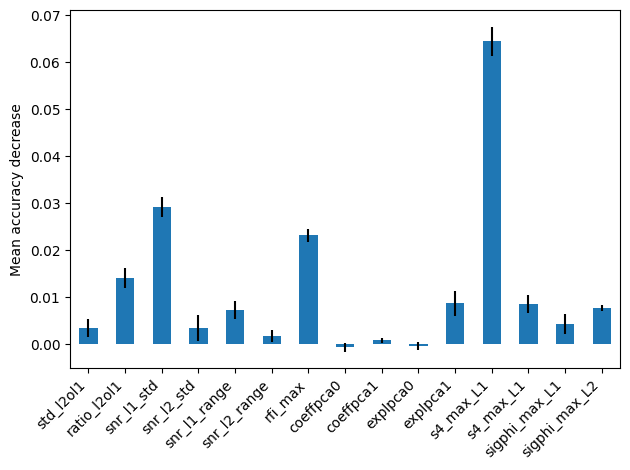

In [12]:
# RANDOM FOREST FEATURE IMPORTANCE
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    ml_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
#ax.set_title("Feature importances using permutation on full XGB model")
ax.set_ylabel("Mean accuracy decrease")
#ax.tick_params(axis='x', labelrotation=45, right=True)
ax.set_xticklabels(feature_names, rotation=45, ha="right")
fig.tight_layout()
if plot_f:
    plt.savefig("../manuscript/feat_import.png", dpi=300)
plt.show()

## 5. Determine optimal thresholds to compare against ML

### Determine Scintillation Threshold

In [13]:
# Determine Optimal thresholds for S4/Sig Phi based upon training
def class_map_binary_scint(y):
    y_new=np.empty(len(y))
    y_new[y==0]=1
    y_new[y==1]=0
    y_new[y==2]=0
    y_new[y==3]=0
    y_new[y==4]=1
    y_new[y==5]=0
    return y_new
#S4
y_train_scint=class_map_binary_scint(y_train)
for thresh in np.arange(0.1,1,.1):
    y_pred_thresh_s4=np.zeros(len(X_train))
    y_pred_thresh_s4[(X_train[:,-4]>thresh)|(X_train[:,-3]>thresh)]=1
    precision, recall, fscore, support=precision_recall_fscore_support(y_train_scint, y_pred_thresh_s4)
    print(thresh, fscore)

#Sig Phi
for thresh1 in np.arange(0.03,.08,.01):
    for thresh2 in np.arange(0.01,.08,.01):
        y_pred_thresh_sig=np.zeros(len(X_train))
        y_pred_thresh_sig[(X_train[:,-2]>thresh1)|(X_train[:,-1]>thresh2)]=1
        precision, recall, fscore, support=precision_recall_fscore_support(y_train_scint, y_pred_thresh_sig)
        print(thresh1, thresh2, fscore)

0.1 [0.14012739 0.12998362]
0.2 [0.70748401 0.20980707]
0.30000000000000004 [0.85337339 0.27743804]
0.4 [0.90615166 0.31207598]
0.5 [0.93156918 0.3335277 ]
0.6 [0.94188377 0.32093664]
0.7000000000000001 [0.94688976 0.2798419 ]
0.8 [0.94840466 0.22454308]
0.9 [0.94987627 0.16330451]
0.03 0.01 [0.27514497 0.13854563]
0.03 0.02 [0.70892124 0.22377065]
0.03 0.03 [0.89638952 0.39314966]
0.03 0.04 [0.92904098 0.46053246]
0.03 0.05 [0.93620637 0.45908389]
0.03 0.060000000000000005 [0.94022363 0.4719701 ]
0.03 0.06999999999999999 [0.94176574 0.47753113]
0.03 0.08 [0.94279342 0.48113723]
0.04 0.01 [0.2753174  0.13856209]
0.04 0.02 [0.70940299 0.22399362]
0.04 0.03 [0.89674017 0.39388288]
0.04 0.04 [0.93081452 0.46641438]
0.04 0.05 [0.9421398  0.46876727]
0.04 0.060000000000000005 [0.94937838 0.47044182]
0.04 0.06999999999999999 [0.95205966 0.46780552]
0.04 0.08 [0.95267915 0.46277666]
0.05 0.01 [0.27617906 0.13864447]
0.05 0.02 [0.71017303 0.2243513 ]
0.05 0.03 [0.89744078 0.39535754]
0.05 0.04

#s4 threshold=0.6
#sigma phi .07,.06

In [14]:
y_li=[]
y_pred_li=[]
y_scint_thr_li=[]
for i,sample in enumerate(np.unique(samples_test[:])):
    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)
        #--- test model
        y_pred = ml_model.predict(X)

        y=class_map_binary_scint(y)
        y_pred=class_map_binary_scint(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

        # Scint threshold
        y_scint=np.zeros(len(X))
        #amp
        y_scint[(X[:,-4]>0.6)|(X[:,-3]>0.6)]=1
        #phse
        y_scint[(X[:,-2]>0.07)|(X[:,-1]>0.06)]=1
        y_scint_thr_li.append([y_scint])
    
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91
        
    except:
        print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_scint_=np.concatenate(y_scint_thr_li, axis=1)[0]


met_li=[]
for name,y_metric in zip([ "Scint Index", "ML"],[y_scint_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
scint_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
scint_met["Score"]=scint_met.Score.astype(np.float16)

[0.92018779 0.40181612]
[0.86849628 0.72540984] [0.27459016 0.13150372] [0.85916622 0.85916622]
[0.96639022 0.62193126]
[0.94939966 0.77868852] [0.22131148 0.05060034] [0.93826831 0.93826831]


### Determine RFI Threshold

In [15]:
def class_map_binary_rfi(y):
    y_new=np.empty(len(y))
    y_new[y==0]=0
    y_new[y==1]=0
    y_new[y==2]=1
    y_new[y==3]=0
    y_new[y==4]=0
    y_new[y==5]=1
    return y_new

# RFI threshold
y_train_rfi=class_map_binary_rfi(y_train)

for thresh in np.arange(0.0001,.005,.0001):
    y_pred_thresh_rfi=np.zeros(len(X_train))
    y_pred_thresh_rfi[(X_train[:,-9]>thresh)]=1
    precision, recall, fscore, support=precision_recall_fscore_support(y_train_rfi, y_pred_thresh_rfi)
    print(thresh, fscore)

0.0001 [0.90868207 0.39285714]
0.0002 [0.93338192 0.43772424]
0.00030000000000000003 [0.94526769 0.45541023]
0.0004 [0.95301219 0.47763158]
0.0005 [0.95575326 0.48027682]
0.0006000000000000001 [0.95891695 0.48265683]
0.0007000000000000001 [0.96193812 0.49378882]
0.0008 [0.9628896  0.49162011]
0.0009000000000000001 [0.96346288 0.48943089]
0.001 [0.96380643 0.48298755]
0.0011 [0.96442871 0.48270042]
0.0012000000000000001 [0.96487771 0.47938144]
0.0013000000000000002 [0.96560908 0.48167539]
0.0014000000000000002 [0.96640259 0.48355556]
0.0015 [0.96636616 0.47755835]
0.0016 [0.96667244 0.47782805]
0.0017000000000000001 [0.96691877 0.47766636]
0.0018000000000000002 [0.96717623 0.47460757]
0.0019000000000000002 [0.96766011 0.47619048]
0.002 [0.96791659 0.4730369 ]
0.0021 [0.9681096  0.47036329]
0.0022 [0.96808327 0.4606414 ]
0.0023 [0.96781609 0.44990177]
0.0024 [0.96811628 0.45103858]
0.0025 [0.96812726 0.44776119]
0.0026 [0.9679605  0.44311377]
0.0027 [0.96803076 0.44020101]
0.0028 [0.9680

In [ ]:
#rfi metric = 0.0017
#Combined: 0.0009


In [16]:
y_li=[]
y_pred_li=[]
y_rfi_thr_li=[]
for i,sample in enumerate(np.unique(samples_test)):
    fn="../data/data/feature_sets/%s.pkl" %sample
    
    try:
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        
        X, y, feature_names, fs_dict=df_2_Xy(fdf)

        # map downlink labels to Comms link
        label_df=pd.read_pickle('../data/converted_labels_comms.pkl')
        if sample in label_df.Filename.values:
            y=class_map_RFI(y)
            
        # rfi threshold
        y_rfi=np.zeros(len(X))
        y_rfi[fdf.rfi_max>0.0009]=1
        y_rfi_thr_li.append([y_rfi])
        #fdf_li.append(fdf)
        #thresh_rfi_labels[fdf.rfi_max>.05]=1# .05:.91

    
        #--- test model
        y_pred =ml_model.predict(X)

        y=class_map_binary_rfi(y)
        y_pred=class_map_binary_rfi(y_pred)
        y_li.append([y])
        y_pred_li.append([y_pred])

    except:
        #print(sample)
        continue

y_=np.concatenate(y_li, axis=1)[0]
y_pred_=np.concatenate(y_pred_li, axis=1)[0]
y_rfi_=np.concatenate(y_rfi_thr_li, axis=1)[0]

met_li=[]
for name,y_metric in zip([ "RFI Index", "ML"],[y_rfi_,y_pred_]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)
rfi_met=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])
rfi_met["Score"]=rfi_met.Score.astype(np.float16)

[0.96856737 0.50374065]
[0.96780303 0.51010101] [0.48989899 0.03219697] [0.94087938 0.94087938]
[0.98434288 0.75794621]
[0.98232323 0.78282828] [0.21717172 0.01767677] [0.97058824 0.97058824]


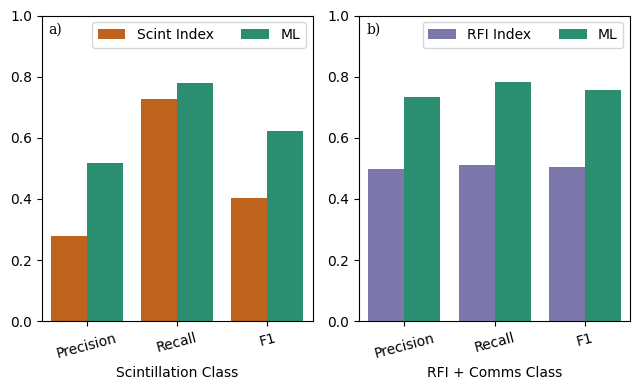

In [17]:

palette = {
    'ML': '#1b9e77',
    'Scint Index': '#d95f02',
    'RFI Index': '#7570b3',
}

fig,axes=plt.subplots(1,2,  figsize=(6.5,4))
for i,(name,df) in enumerate(zip(['Scintillation Class', 'RFI + Comms Class'],[scint_met, rfi_met])):
    sns.barplot(df, x="Metric", y="Score", hue="Model", palette=palette, ax=axes[i]).set(
    xlabel=name, 
    ylabel=None
)
    axes[i].legend(loc='upper right',ncol=3)
    axes[i].tick_params(axis='x', labelrotation=15)
    axes[i].set_ylim([.0,1.])

import string
alph_li=list(string.ascii_lowercase)
alph_li=[s + ')' for s in alph_li]
for j,label in enumerate(alph_li[:len(axes)]):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    axes[j].annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
fig.tight_layout()
if plot_f:
    plt.savefig("../manuscript/compare_f1_thresh.png", dpi=300)

## 6. Examples of model performance

[0 0 0 1 0 0 0 0 0 1 0 0]


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


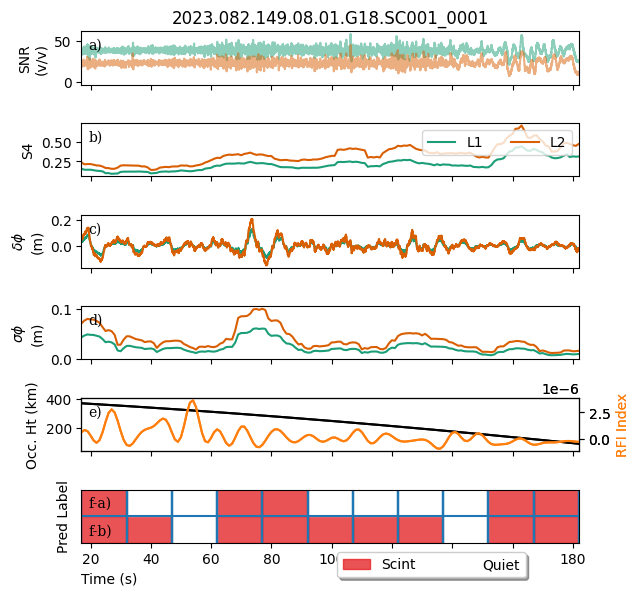

In [18]:



sample='2023.082.149.08.01.G18.SC001_0001' #phase and ampli
lv1, lv2, y_pred, y_true, fs_dict = sample_2_DFandXy(sample, ml_model)
plot_leo_ml_multi(sample, lv1, lv2, y_pred, y_true, fs_dict['time'], LABELS, plot_f=plot_f)


[0 0 0 0 5 5 5 5 5 5]


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


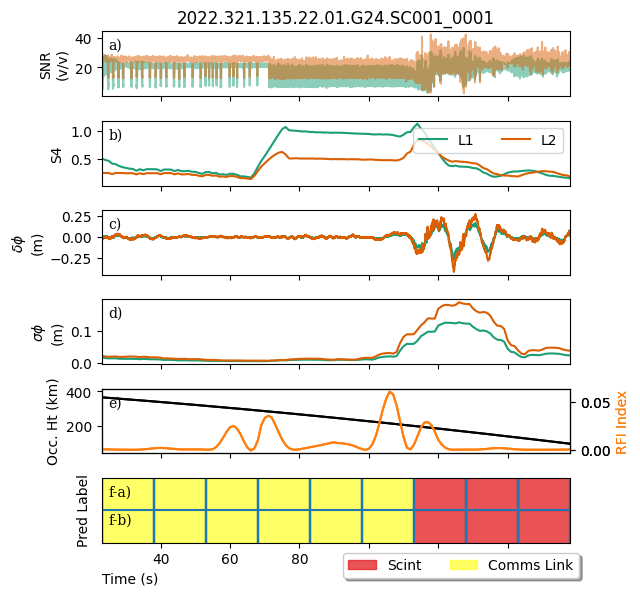

In [19]:
sample = '2022.321.135.22.01.G24.SC001_0001' #rfi and scint
lv1, lv2, y_pred, y_true, fs_dict = sample_2_DFandXy(sample, ml_model)
plot_leo_ml_multi(sample, lv1, lv2, y_pred, y_true, fs_dict['time'], LABELS, plot_f=plot_f)


[1 1 1 1 2 2 1 1 1 1]


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


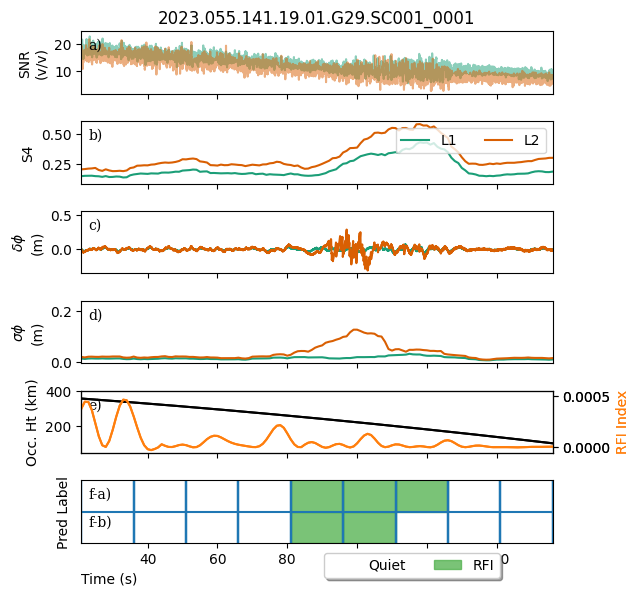

In [20]:
sample = '2023.055.141.19.01.G29.SC001_0001' #RFI
lv1, lv2, y_pred, y_true, fs_dict = sample_2_DFandXy(sample, ml_model)
plot_leo_ml_multi(sample, lv1, lv2, y_pred, y_true, fs_dict['time'], LABELS, plot_f=plot_f)